![Fraud](./img/Fraud.png)
# Employment Scam Aegean Dataset
## 0. Imports and global settings

In [1]:
import scripts.plots as plots
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import FreqDist, RegexpTokenizer, word_tokenize
import pandas as pd
import re
import seaborn as sns
import string
import warnings
from wordcloud import WordCloud

sns.set(palette='RdYlGn', context='talk', rc={'figure.figsize':(15,15)})
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

## 0.1 Creating dataframes

In [2]:
df = pd.read_csv("./data/fake_job_postings.csv", index_col='job_id')
df.columns = df.columns.str.title()

In [3]:
dflegit = df[df['Fraudulent']==0]
dffraud = df[df['Fraudulent']==1]

In [4]:
df.sample(n=50)

,Title,Location,Department,Salary_Range,Company_Profile,Description,Requirements,Benefits,Telecommuting,Has_Company_Logo,Has_Questions,Employment_Type,Required_Experience,Required_Education,Industry,Function,Fraudulent
job_id,,,,,,,,,,,,,,,,,
14867,SAP Functional Solution Architect,"US, VA, Winchester",NaN,NaN,NaN,Must be US Citizen for this position.Role: SAP...,NaN,NaN,0,0,0,Contract,Mid-Senior level,NaN,Information Technology and Services,NaN,0
5147,Java / J2ee Developers,"CA, ON, Markhan",NaN,NaN,Q2Hire has been delivering concrete results fo...,"The client, a globally focused software compan...","• Bachelors degree in Computer Science, Engine...",NaN,0,1,1,NaN,NaN,NaN,NaN,NaN,0
8912,Network/System Administrator/Engineer,"US, GA, Atlanta",NaN,NaN,Leapfrog Services provides managed IT services...,As an Escalations Engineer you will be part of...,Technical (Minimum of 5 years industry experie...,Leapfrog Services provides managed IT services...,0,1,1,Full-time,Associate,NaN,Information Technology and Services,Information Technology,0
10422,Talent Manager,"CA, ON, Toronto",People & Culture,NaN,Vend is looking for some awesome new talent to...,First things first….. If you don’t know alread...,To be successful in this role at Vend you will...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Associate,NaN,Staffing and Recruiting,Human Resources,0
12568,"Internship, Visa and Passport Agency","US, DC, Washington",Operations,NaN,VisaHQ hires a diverse and internationally min...,#URL_d66665a1f44c600050fa53a8b3eb6066c3c04f7d7...,#NAME?,About #URL_d66665a1f44c600050fa53a8b3eb6066c3c...,0,1,0,Other,Internship,NaN,"Leisure, Travel & Tourism",NaN,0
8693,Payroll Clerk,"US, IN, INDIANAPOLIS",Accounting/Payroll,NaN,At DynCorp International it is our commitment ...,Payroll Clerk Job Purpose: Responsible for Com...,Required Tools Needed below:1. A good computer...,NaN,0,1,0,Full-time,Entry level,High School or equivalent,Accounting,Finance,1
8180,Senior PHP Developer,"IN, KA, Bangalore",NaN,250000-300000,NaN,"Responsiblities Design, build and maintain our...",NaN,Sweat Equity offered : 1% to 10% depending on ...,0,0,1,Full-time,Associate,Bachelor's Degree,Internet,Information Technology,0
16467,Automation Process Control Technician,"US, IA, Cedar Rapids",Maintenance,NaN,"Red Star Yeast Company LLC (RSYC), a leader in...","Red Star Yeast Company LLC (RSYC), a leader in...","Education: College degree in Computer Science,...","Full-time, Hourly Non-exempt Position401K with...",0,1,0,Full-time,Associate,Some College Coursework Completed,Industrial Automation,Information Technology,0
7666,Document Processing Assistant,"US, KS, Kansas City",NaN,NaN,NaN,We are seeking individuals to be connected wit...,Home Office SuppliesComputer with internet acc...,NaN,1,0,0,NaN,Entry level,Some High School Coursework,NaN,Administrative,1


## 1. Missing values
Let's have a look at the data and see if there are any missing values.

In [5]:
_nalegit = pd.DataFrame(index=['Legit_HasValue','Legit_IsNA'])
_nafraud = pd.DataFrame(index=['Fraud_HasValue', 'Fraud_IsNA'])
for header in dflegit.columns:
    _nalegit[header] = dflegit[header].isna().value_counts()[0]
_nalegit.loc['Legit_IsNA'] = 17014 - _nalegit.loc['Legit_HasValue']
for header in dffraud.columns:
    _nafraud[header] = dffraud[header].isna().value_counts()[0]
_nafraud.loc['Fraud_IsNA'] = 866 - _nafraud.loc['Fraud_HasValue']
_nalegit = (round(_nalegit/17014*100, 1)).T
_nafraud = (round(_nafraud/866*100,1)).T
_na = _nalegit.merge(_nafraud,how='inner',left_on=_nalegit.index, right_on=_nafraud.index)
_na = _na.set_index(_na['key_0']).drop(columns='key_0')
_na.index.names = ['Columns']
_na

,Legit_HasValue,Legit_IsNA,Fraud_HasValue,Fraud_IsNA
Columns,,,,
Title,100.0,0.0,100.0,0.0
Location,98.1,1.9,97.8,2.2
Department,35.3,64.7,38.7,61.3
Salary_Range,15.5,84.5,25.8,74.2
Company_Profile,84.0,16.0,32.2,67.8
Description,100.0,0.0,99.9,0.1
Requirements,85.1,14.9,82.2,17.8
Benefits,59.8,40.2,58.0,42.0
Telecommuting,100.0,0.0,100.0,0.0


17014


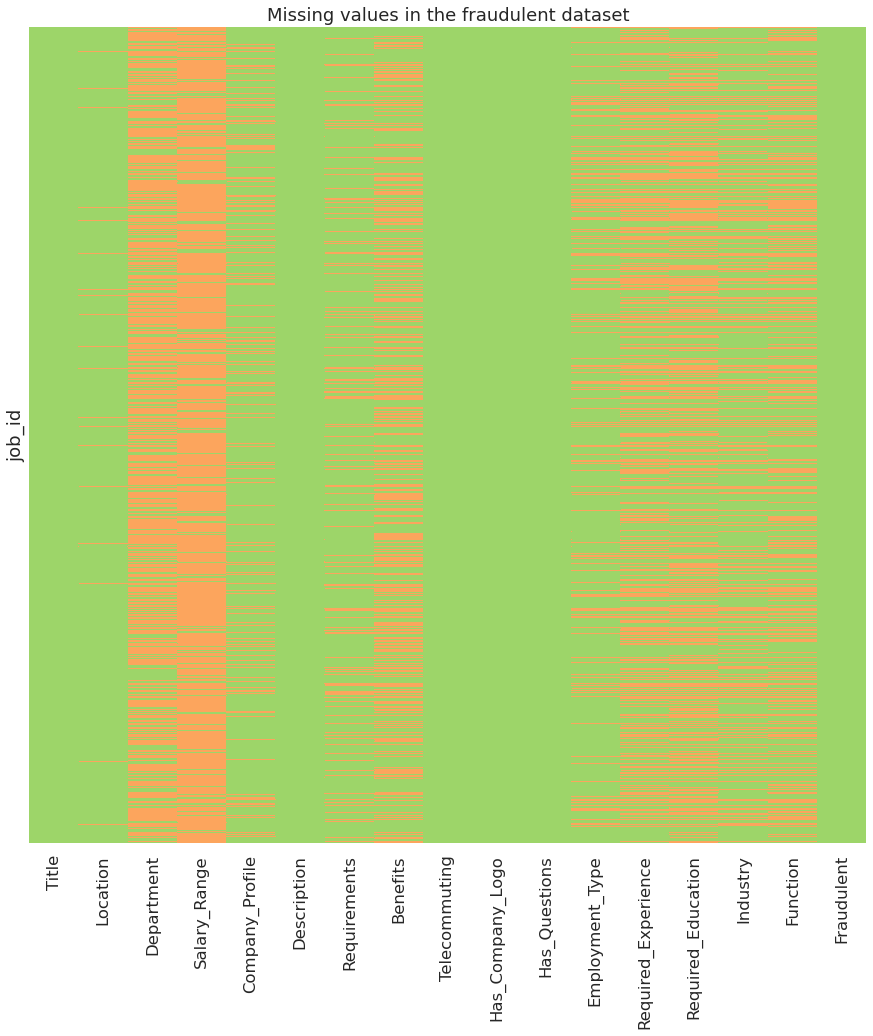

In [6]:
print(len(dflegit))
sns.heatmap(dflegit.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

866


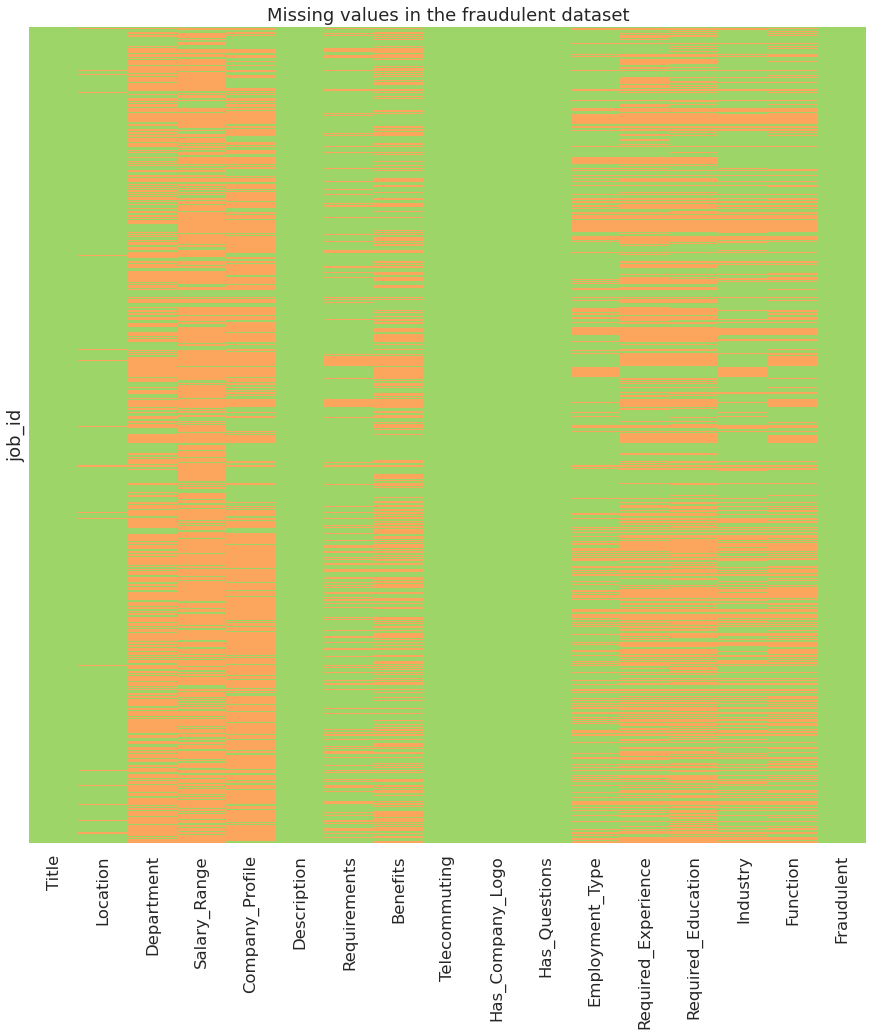

In [7]:
print(len(dffraud))
sns.heatmap(dffraud.isnull(), yticklabels=False, cbar=False, cmap=[sns.color_palette()[4],sns.color_palette()[1]]);
plt.title('Missing values in the fraudulent dataset');

## 1.1 Insight
This dataset contains 17880 jobs, with a maximum of 16 characteristics given to each job. On top of this information, all jobs entry have been assigned manually a "fraudulent" value of 1 (the post is fraudulent) or 0 (the post is legitimate); this resulted in 17014 job offers flagged as genuine whilst 866 were identified as fraudulent.

_Note: This assignment was done manually. Errors might have occurred._

The informations given for each job is separated in the following variables:

| Number | Title | Data type |
|---:|:---:| ---|
| 01 | title | text |
| 02 | location | text |
| 03 | department | text |
| 04 | salary_range | text |
| 05 | company_profile | text |
| 06 | description | text |
| 07 | requirements | text |
| 08 | benefits | text |
| 09 | telecommuting | binary |
| 10 | has_company_logo | binary |
| 11 | has_questions | binary |
| 12 | employment_type | categorical |
| 13 | required_experience | categorical |
| 14 | required_education | categorical |
| 15 | industry | categorical |
| 16 | function | categorical |
| 17 | fraudulent | binary |

There tend to be some repetitions in some fields; `company_profile` is an obvious one but, `description` can be very similar in some cases. These repetitions might affect tf-idf scores and might require a more in-depth analysis.

As the missing table shows, fraudulent posts tend to have more missing values than legitimate job posts, especially when it comes down to company profile. However, they seem to be rather keen on giving information about the salary range. Only one job doesn't have a job description (`df[df['description'].isna()==True]`); it is a fraudulent post for a position as an Office Manager in Warsaw, PL.

## 2. Text fields
From the missing value visualisation, we can see the fraudsters are struggling with the company profiles, etc. Let's look at text fields, in general, to see how creative the fraudsters are.
### 2.1 Trimming the text
There is some textual artefact that ned to be removed in order to have a more efficient word analysis.

In the following code,
- The first line will put a space before every capital letter (to avoid a wo.Rd scenario).
- The second line will remove the anonymised contact information.
- The third line will remove non-word characters, including digits.
- The fourth line will remove words shorter than three characters.
- The fifth line will convert multiple spaces into one space only.

In [8]:
for column in df.columns[4:8]:
    df[column].replace('([A-Z][a-z]|[A-Z] )', r' \1', regex=True, inplace=True)
    df[column].replace('(#URL\w+|#PHONE\w+|#EMAIL\w+)', ' ', regex=True, inplace=True)
    df[column].replace('(\\W|\\d)', ' ', regex=True, inplace=True)
    df[column].replace(r'\b\w{1,3}\b', ' ', regex=True, inplace=True)
    df[column].replace('\ +', ' ', regex=True, inplace=True)

### 2.2 Word Count

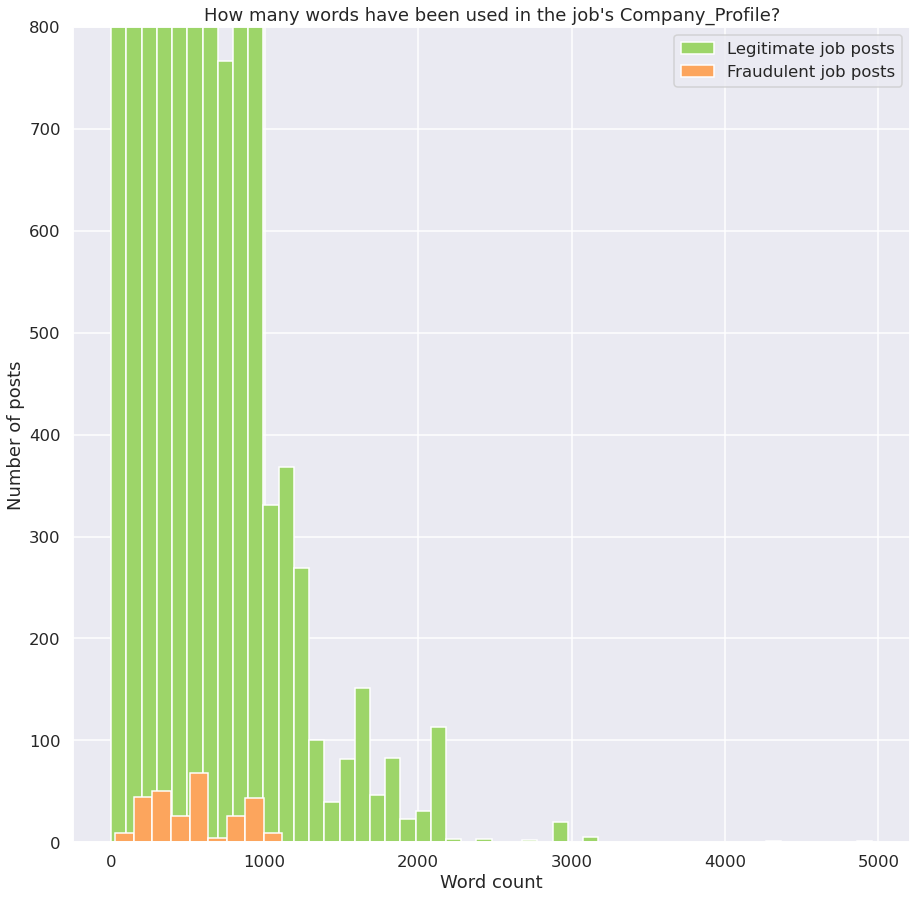

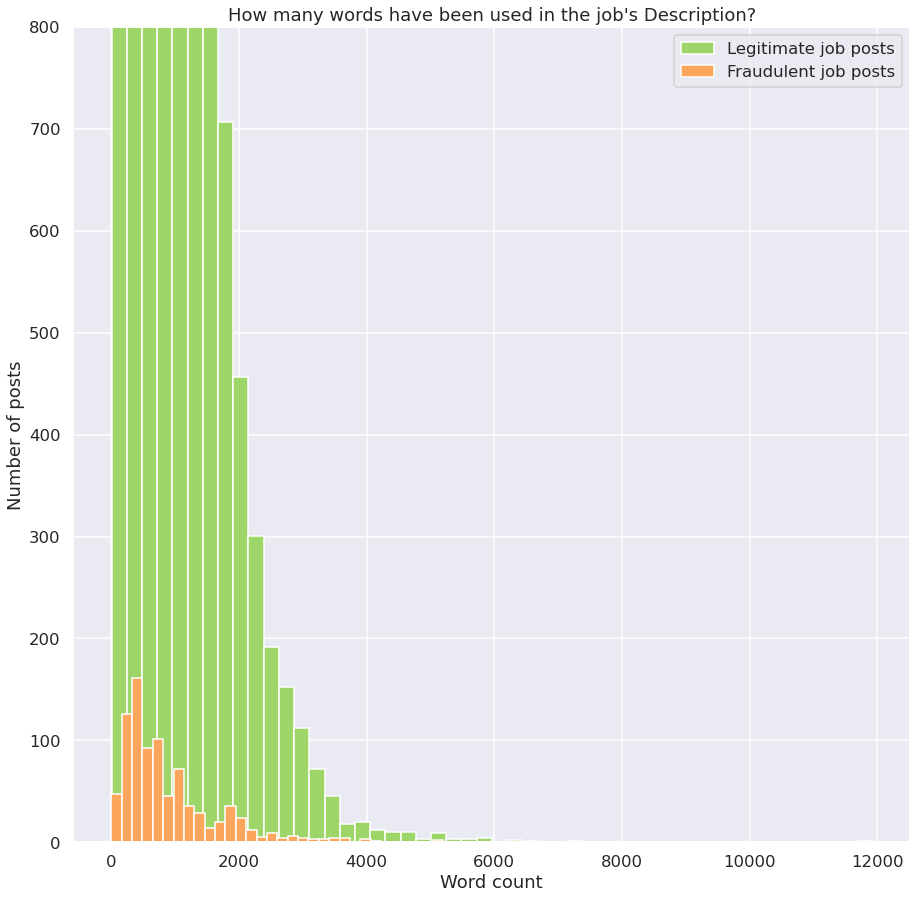

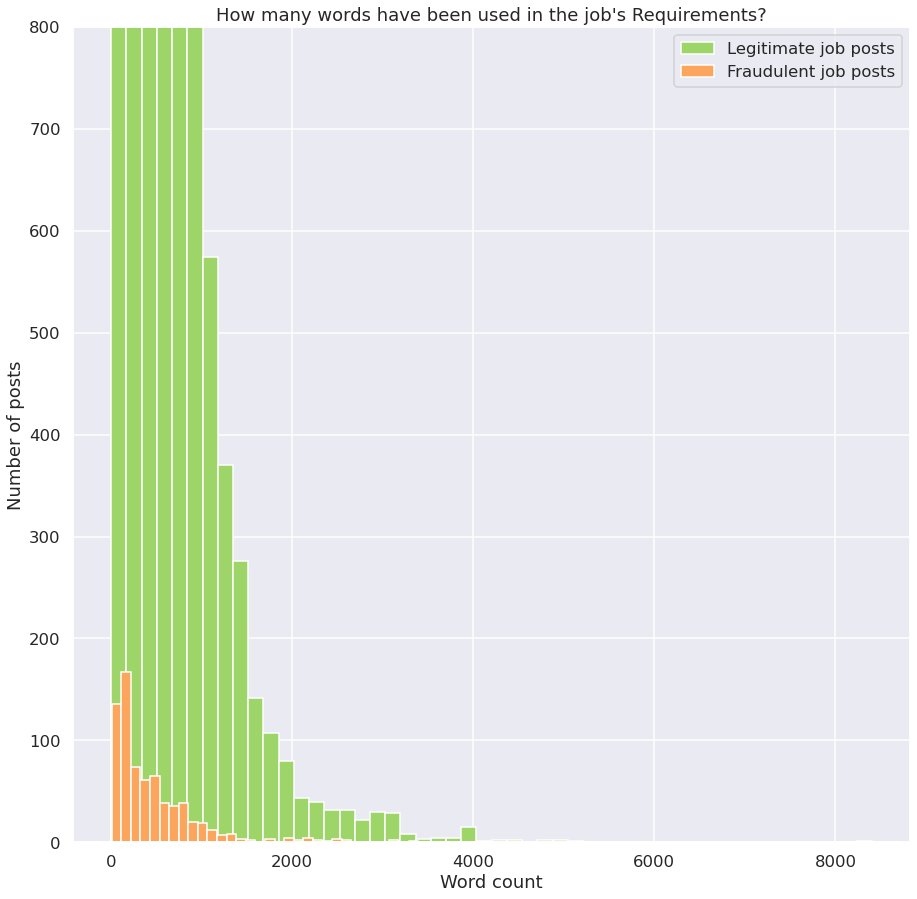

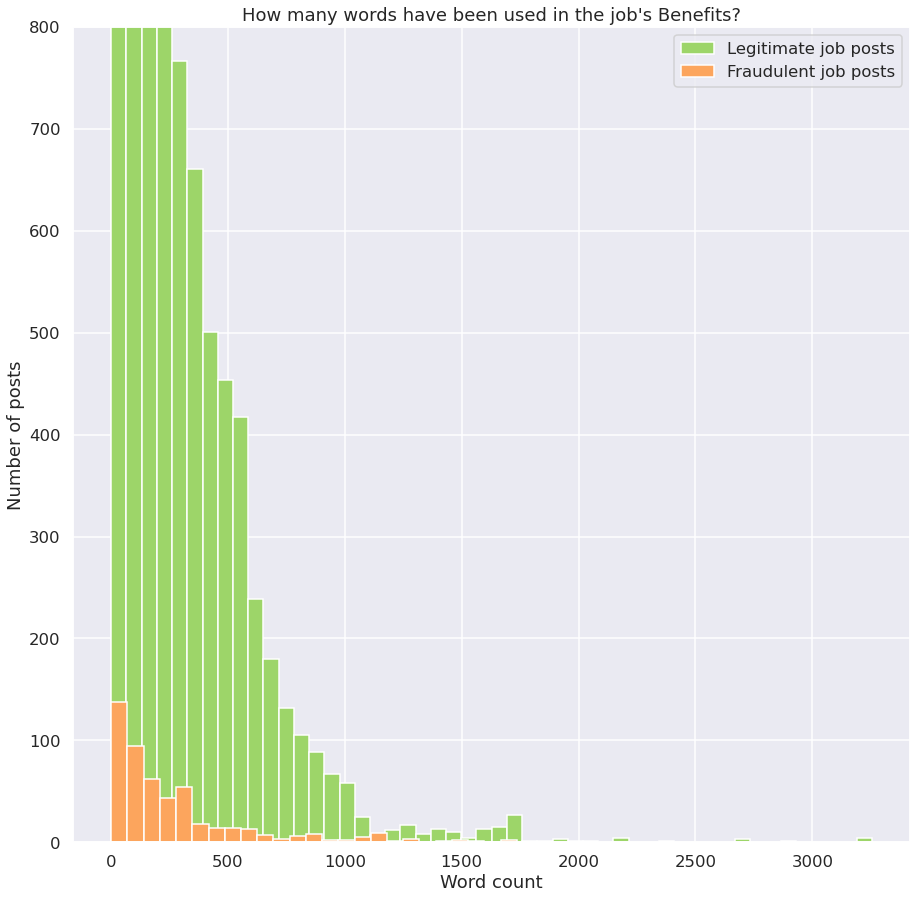

In [9]:
plots.Plots.word_dist_plot(df,4,8)

Not only are fraudulent job posts less complete than legitimate ones but, even when there is information, the fraudulent job posts are less loquacious than genuine job posts. This is especially true for job requirements and company_profile.

Let's have a more detailed look at the content itself.
### 2.3 Word Analysis

In [10]:
# Removing stopwords
stop_words = list(string.punctuation)
stop_words += stopwords.words('english')
stop_words += [i for i in 'qwertyuioplkjhgfdsazxcvbnm']

In [11]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dffraud['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

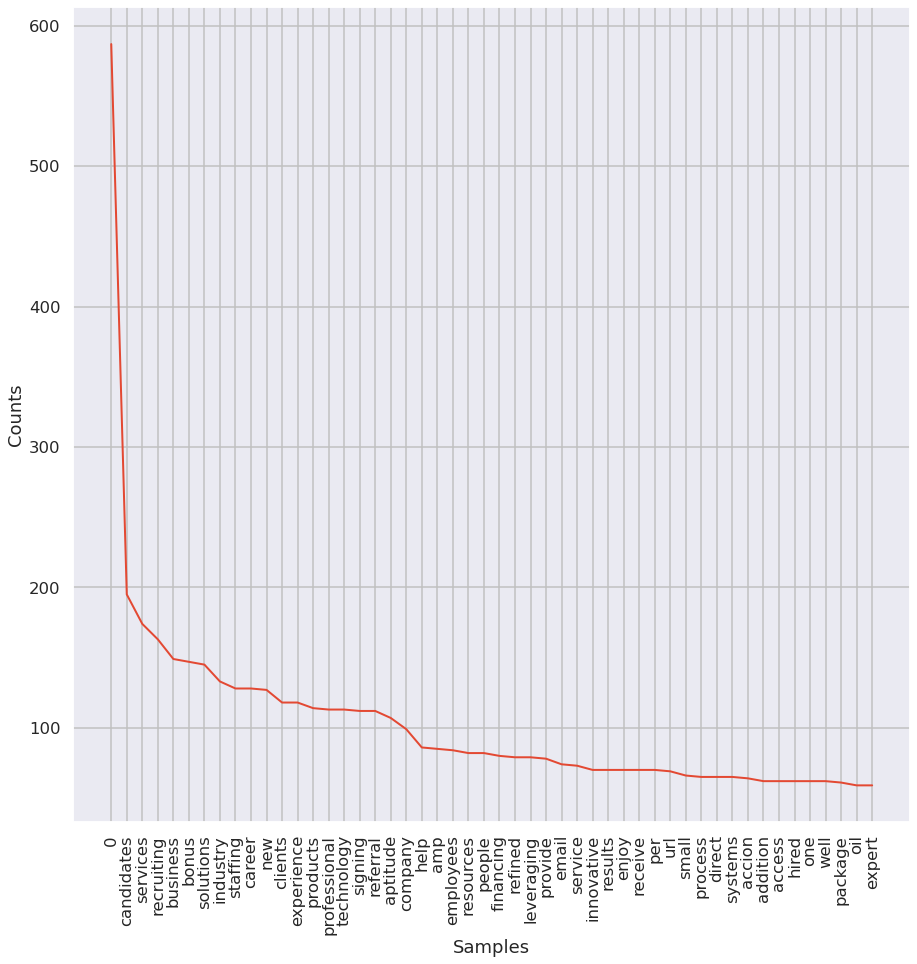

In [12]:
FreqDist(tokens_cp).plot(50)
plt.show()

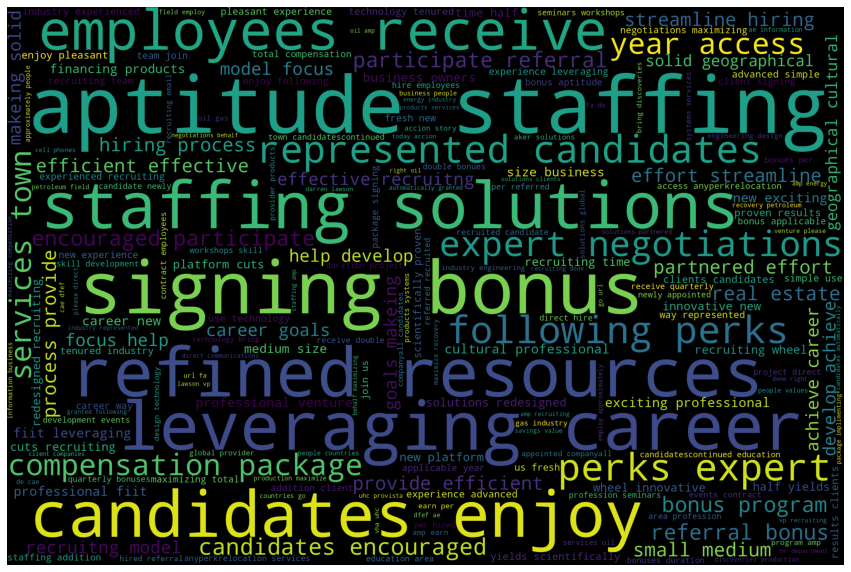

In [13]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
tokens = []
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

for profile in dflegit['Company_Profile']:
    if isinstance(profile, str):
        tokenized_profile = tokenizer.tokenize(profile)
        for word in tokenized_profile:
            tokens.append(word.lower())
    else:
        tokens.append('0')

tokens_cp = [word for word in tokens if word not in stop_words]

In [15]:
len(tokens_cp)
# 948364 for df
# 18771 for dffraud
# 1019554 for dflegit

1019554

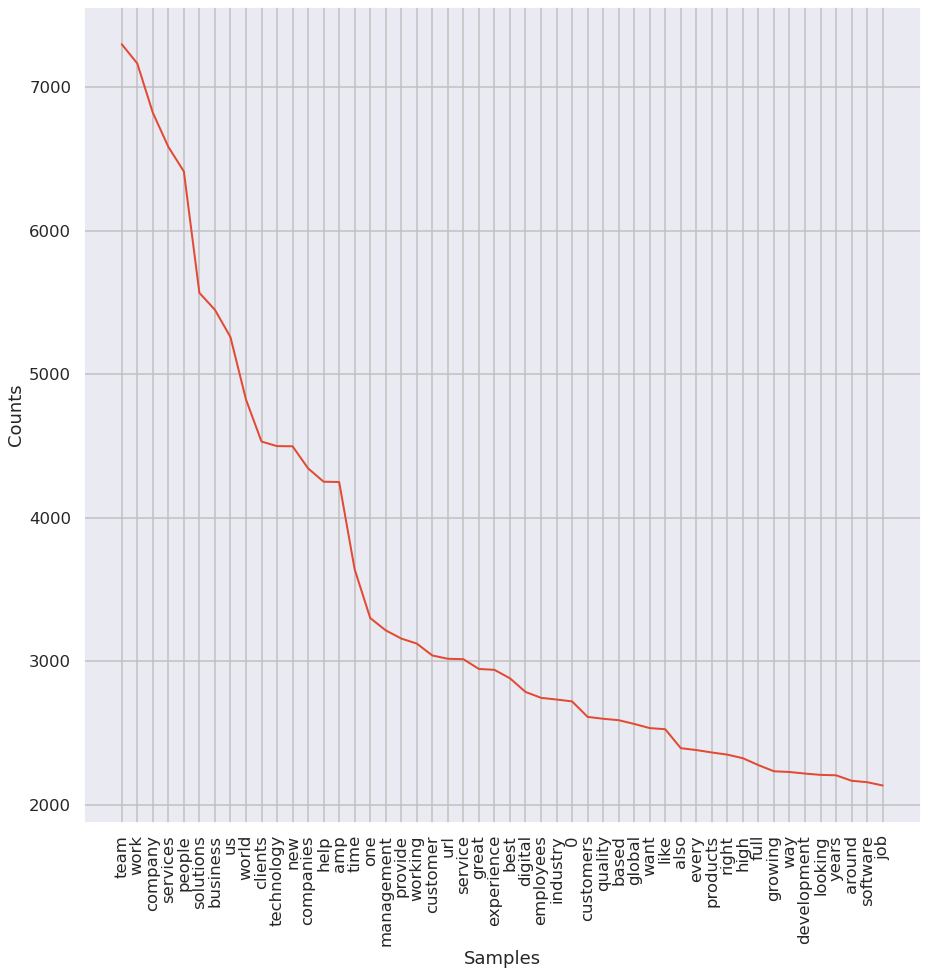

In [16]:
FreqDist(tokens_cp).plot(50)
plt.show()

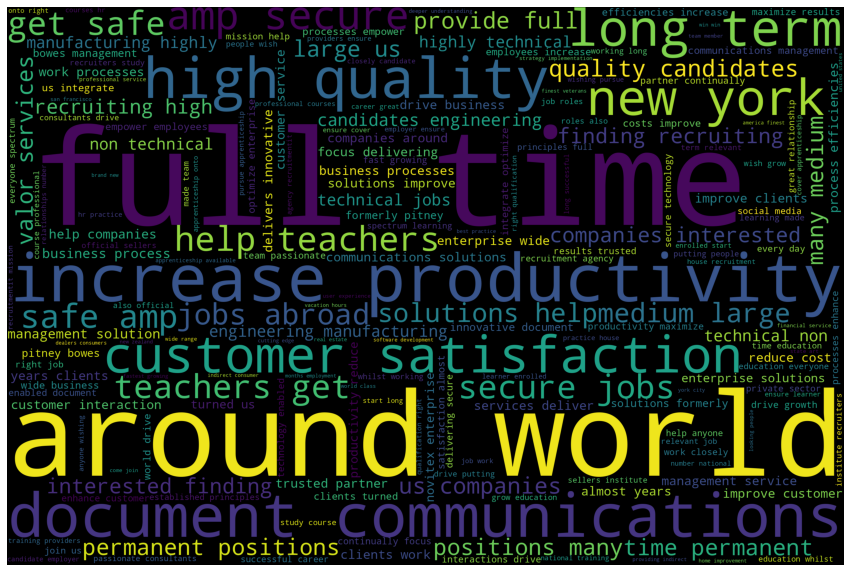

In [17]:
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      stopwords = stop_words)

wordcloud.generate(" ".join(tokens_cp))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Looking at the content of fraudulent ads, it appears, the company profile would be more individual focussed, with terms like candidates, recruiting, bonus, staffing, career, signing, referral, etc.

A legitimate company seem to be more mission focussed with terms like team, people, solutions, help, business, etc.
## 3. Categorical information

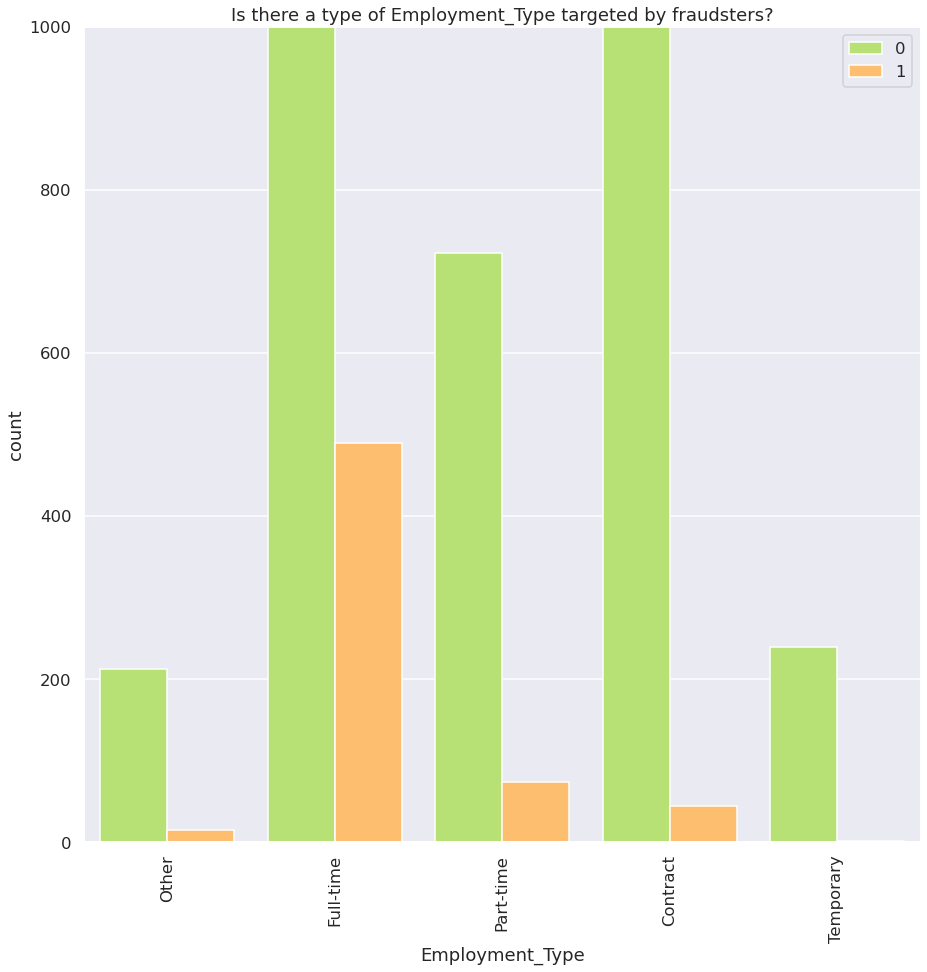

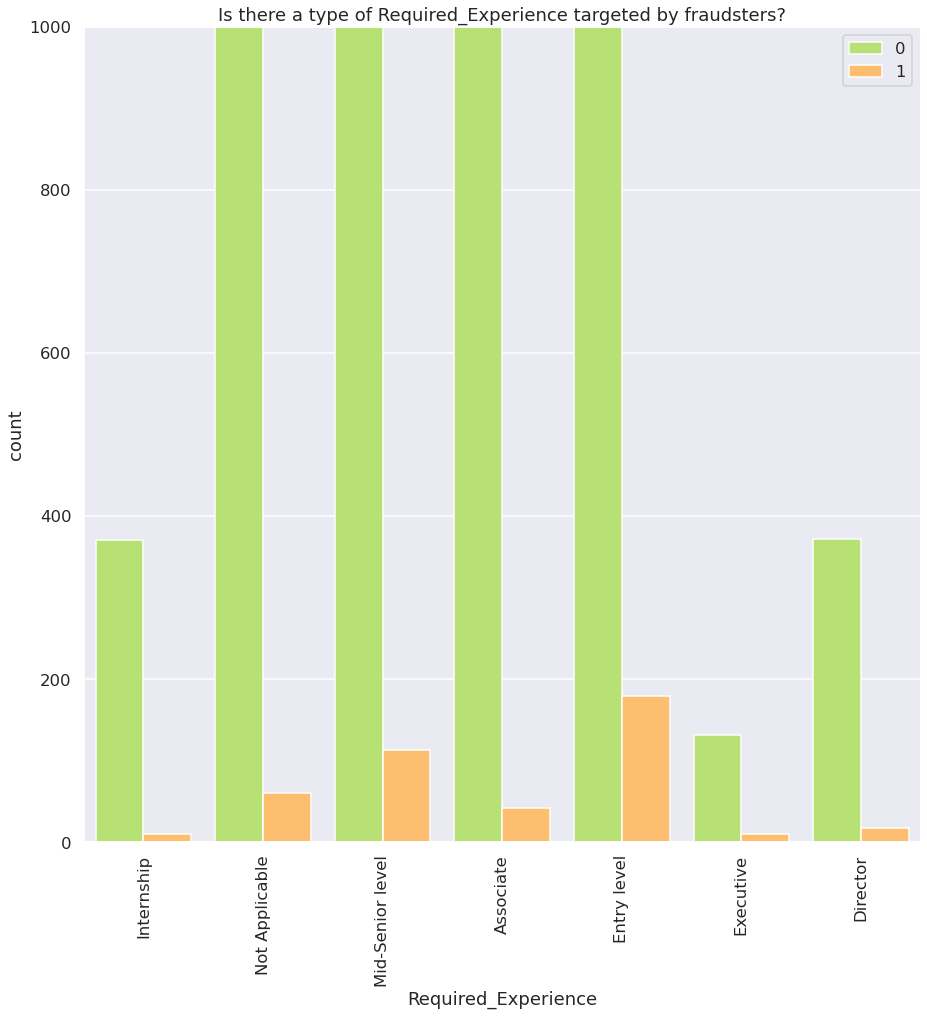

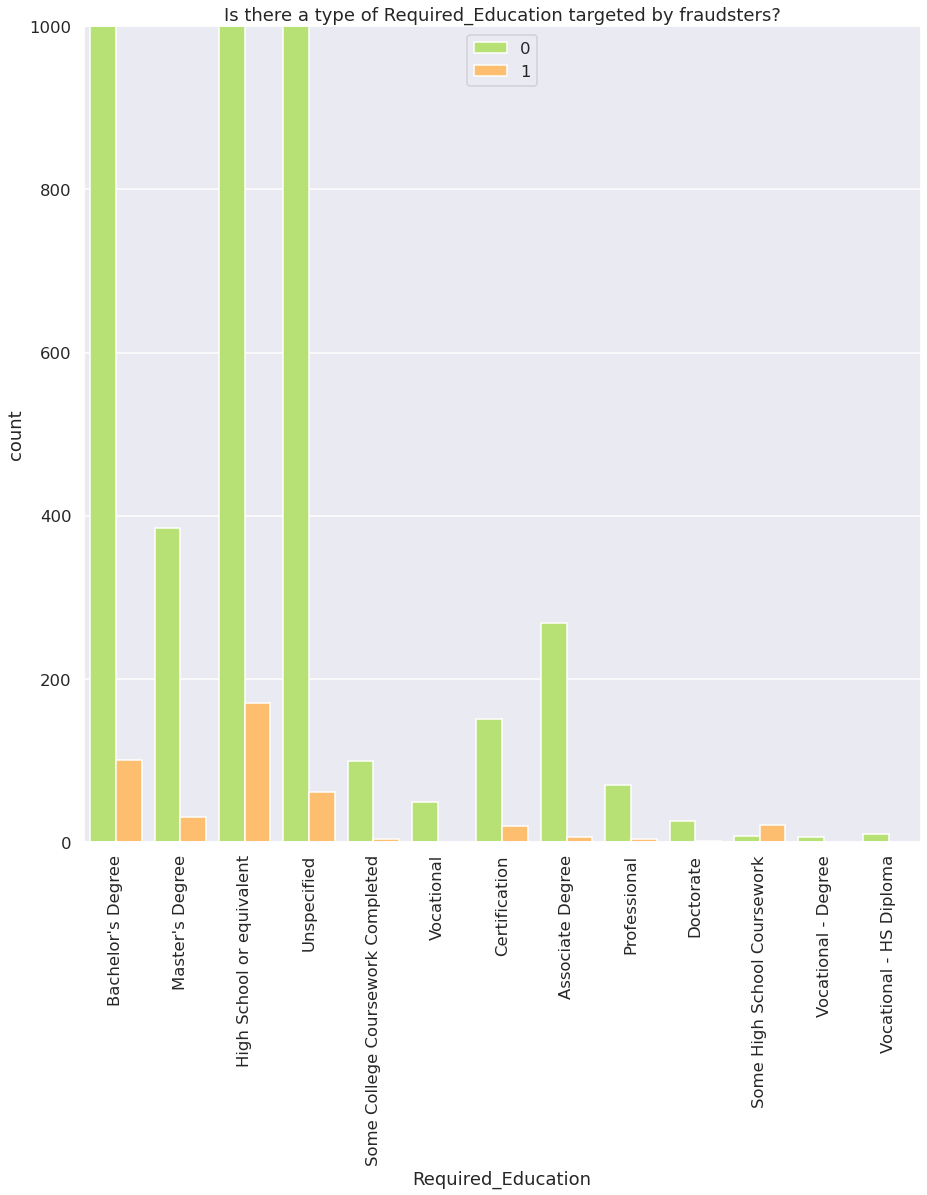

In [18]:
plots.Plots.count_plot(df,11,14)

## 4. Extracting extra information

Some job offers have a phone, email and/or external URL information:

In [19]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)
    
df = df.assign(HasEMAIL=0, HasPHONE=0, HasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['HasURL'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#PHONE_')!=-1:
            df['HasPHONE'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#EMAIL_')!=-1:
            df['HasEMAIL'][i] = 1

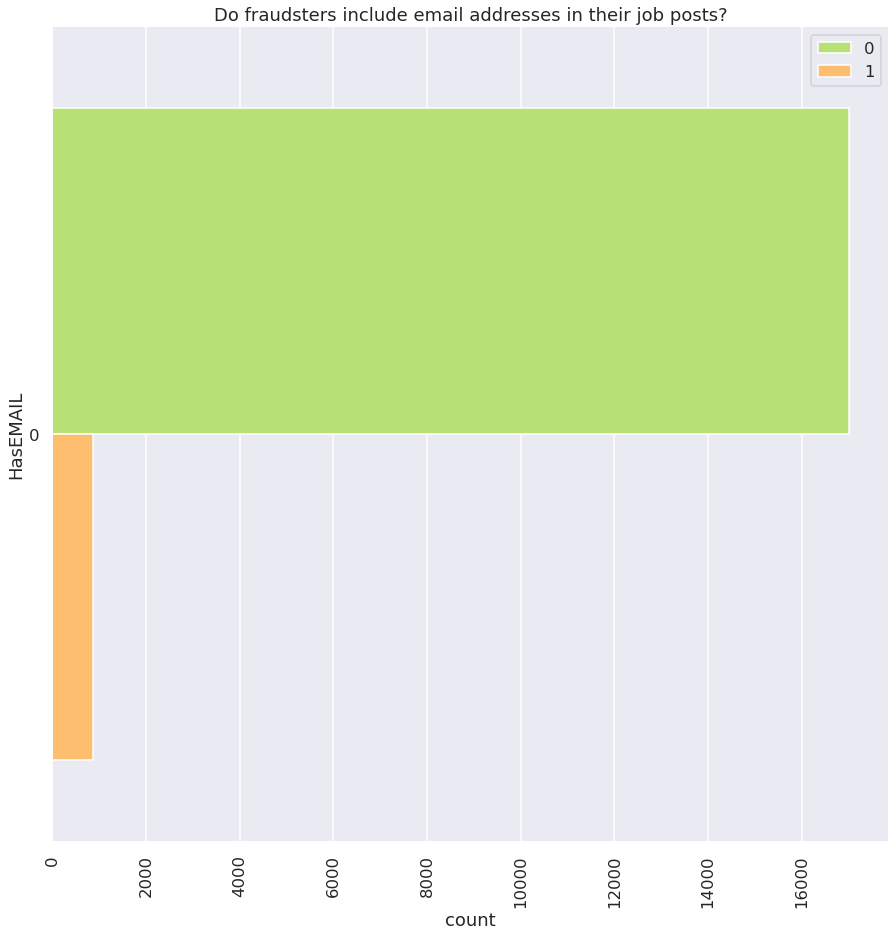

In [20]:
sns.countplot(y='HasEMAIL', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include email addresses in their job posts?")
plt.xticks(rotation=90);
plt.legend();

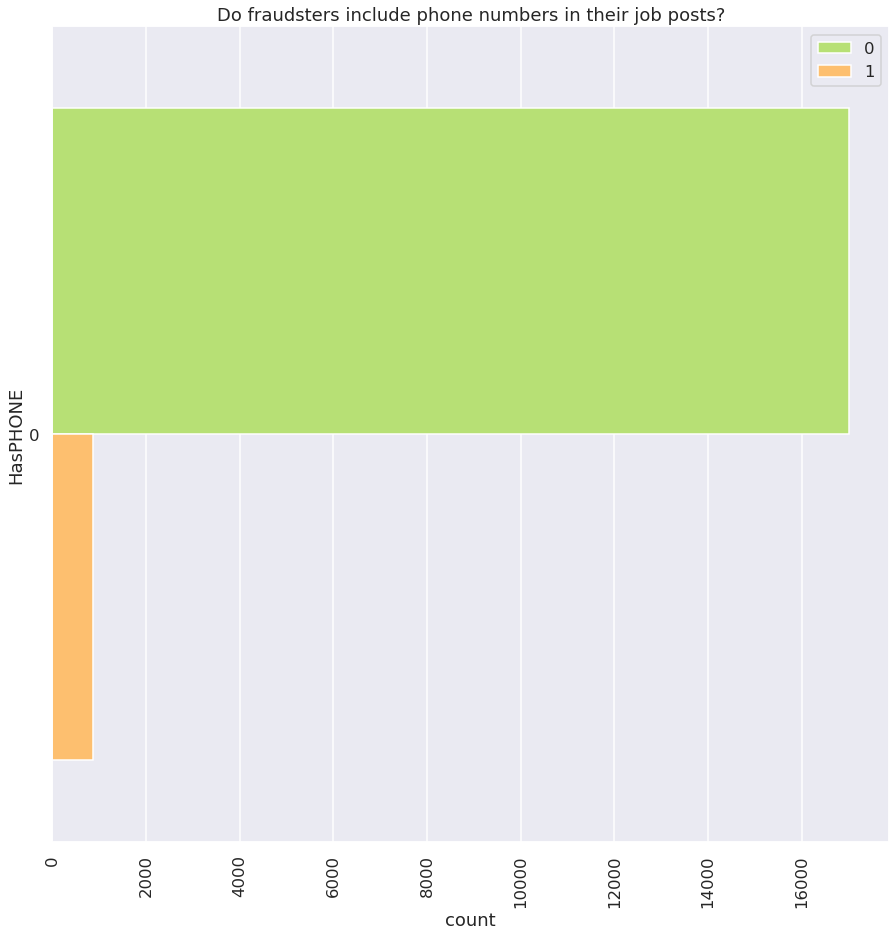

In [21]:
sns.countplot(y='HasPHONE', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include phone numbers in their job posts?")
plt.xticks(rotation=90);
plt.legend();

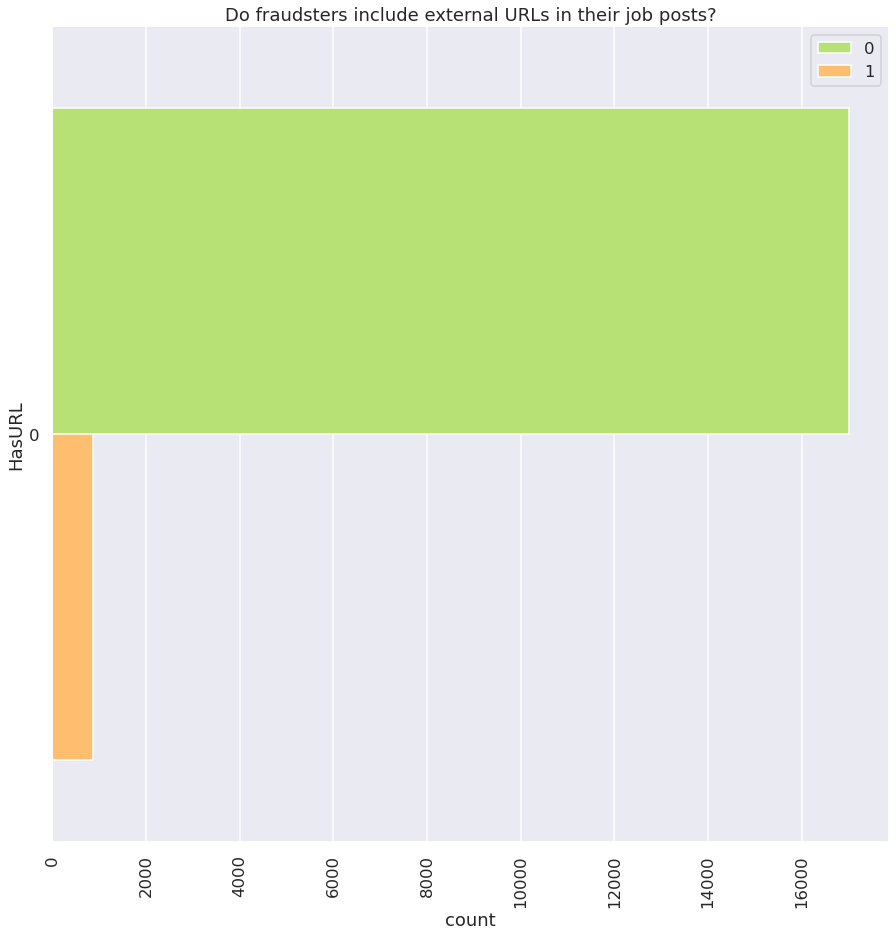

In [22]:
sns.countplot(y='HasURL', hue='Fraudulent', palette='RdYlGn_r', data=df, saturation=1, orient='h')
plt.title("Do fraudsters include external URLs in their job posts?")
plt.xticks(rotation=90);
plt.legend();

## 5. Conclusion
Unfortunately looking at the metadata is not going to be enough to identify fraudulent job posts. The fraudulent job posts follow the same pattern as legitimate job posts except:
* they tend to be lacking more information than the genuine job offers but, fraudsters will make an effort for information such as location, department, function and especially salary_range.
* when information is provided, it will tend to be shorter, the text is going to be more succinct. This characteristic is especially true for the company profile and the job requirements fields.

In terms of content, fraudulent posts will:
* target 'High school degrees or equivalent' and 'Bachelor's Degree' more than any other type of education; Doctorate, Associate Degrees and Vocational were not particularly targeted, some even not targeted at all (in this dataset at least).
* mostly advertise full-time and part-time positions. There are a few fraudulent contractor positions but, proportionally less than any other type of position and temporary contracts were not targeted at all (in this dataset at least).
* target all types of experience but mainly entry-level positions. Once again, Associates are less exposed whilst Directors, Executive and Mid-Senior levels are a little less exposed too.
* tend to refer an URL.  This URL is potentially linking to a website that will infect the victim's computer but, as phone, emails and URLs have been anonymised, it is impossible to confirm this hypothesis.
* NOT communicate a phone number. But most job ads don't anyways.

I hope this gives you a little bit more understanding of fraudulent job offers. The [following notebook](./index.ipynb) will go deeper in the analysis of this dataset and will result in the creation of a classification model helping identify the legitimacy of job posts.